In [115]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Clone GitHub repository
!git clone https://github.com/Amirtalebi83/GNN-OptimalPowerFlow.git
%cd GNN-OptimalPowerFlow

# Check the contents of the cloned repo
!ls


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'GNN-OptimalPowerFlow' already exists and is not an empty directory.
/content/GNN-OptimalPowerFlow/GNN-OptimalPowerFlow/GNN-OptimalPowerFlow
 Datasets   document  'jupyter notebook'   README.md


In [109]:
# Install PyTorch and PyTorch Geometric
!pip install torch
!pip install torch-geometric
!pip install pandas openpyxl  # For data handling


In [124]:
!git reset --hard HEAD #Reset Any Local Changes:
!git pull origin main #Pull the Latest Changes from GitHub:

HEAD is now at 977e02c FS
From https://github.com/Amirtalebi83/GNN-OptimalPowerFlow
 * branch            main       -> FETCH_HEAD
Already up to date.


In [130]:
%cd /content #Remove the local folder and cloning the repository again:
!rm -rf GNN-OptimalPowerFlow

[Errno 2] No such file or directory: '/content #Remove the local folder and cloning the repository again:'
/content
Cloning into 'GNN-OptimalPowerFlow'...
remote: Enumerating objects: 245, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 245 (delta 23), reused 68 (delta 17), pack-reused 168 (from 1)
Receiving objects: 100% (245/245), 149.75 MiB | 38.58 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [125]:
!git clone https://github.com/Amirtalebi83/GNN-OptimalPowerFlow.git
!ls -la GNN-OptimalPowerFlow

total 36
drwxr-xr-x 6 root root  4096 Nov 14 03:55  .
drwxr-xr-x 7 root root  4096 Nov 14 03:55  ..
drwxr-xr-x 5 root root  4096 Nov 14 03:55  Datasets
drwxr-xr-x 2 root root  4096 Nov 14 03:55  document
drwxr-xr-x 8 root root  4096 Nov 14 03:55  .git
drwxr-xr-x 2 root root  4096 Nov 14 03:55 'jupyter notebook'
-rw-r--r-- 1 root root 10321 Nov 14 03:55  README.md


# **Import Libraries**





In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.nn as pyg_nn
from torch_geometric.nn import GCNConv, GraphConv, SAGEConv, GATConv, ChebConv
from torch_geometric.data import Data, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set print options for better readability
np.set_printoptions(precision=5, suppress=True)
torch.set_printoptions(precision=5, sci_mode=False)


In [8]:
!pip install pandapower

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 55.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 5.3 MB/s eta 0:00:00
  Created wheel for pandapower: filename=pandapower-2.14.11-py3-none-any.whl size=13131028 sha256=b0ec6f7d186e622ddc601d70000c7ef6de5f29dc0fbd60bb201ca63f319ee2cf
  Stored in directory: /root/.cache/pip/wheels/7f/de/5a/7b00f385eb06d1fb1f7c1cd06f9bb901709c038d3899548cf1
Successfully built pandapower


# **Dataset Preparation**

In [9]:
import pandapower as pp
import pandapower.networks as nw
import torch
import pandas as pd
from torch_geometric.data import Data, DataLoader

In [68]:
from operator import is_
def slice_dataset(dataset, percentage):
    data_size = len(dataset)
    return dataset[:int(data_size * percentage / 100)]

def make_dataset(dataset, n_bus):
    x_raw, y_raw = [], []

    for i in range(len(dataset)):
        x_sample, y_sample = [], []
        for n in range(n_bus):
            # Define bus type: Slack (1), PQ (2), PV (3)
            is_pv = 0
            is_pq = 0
            is_slack = 0
            if n == 0:  # Slack bus is always bus 0
                is_slack = 1
            elif dataset[i, 4 * n + 2] == 0:  # Q = 0 indicates PV bus
                is_pv = 1
            else:
                is_pq = 1  # PQ bus

            # Include P, Q, V, delta, and bus type as features
            x_sample.append([
                dataset[i, 4 * n + 1],  # P
                dataset[i, 4 * n + 2],  # Q
                dataset[i, 4 * n + 3],  # V
                dataset[i, 4 * n + 4],  # delta
                is_pv,                # Bus type
                is_pq,
                is_slack
            ])

            # Use P and Q as targets
            y_sample.append([
                dataset[i, 4 * n + 1],  # P (target)
                dataset[i, 4 * n + 2],   # Q (target)
                # dataset[i, 4 * n + 3],   # V (target)
                # dataset[i, 4 * n + 4]   # D (target)
            ])

        x_raw.append(x_sample)
        y_raw.append(y_sample)

    # Convert to PyTorch tensors
    x_raw = torch.tensor(x_raw, dtype=torch.float)
    y_raw = torch.tensor(y_raw, dtype=torch.float)
    return x_raw, y_raw


In [69]:
def normalize_dataset(x, y):
    # Compute mean and standard deviation for features and targets
    x_mean, x_std = torch.mean(x, 0), torch.std(x, 0)
    y_mean, y_std = torch.mean(y, 0), torch.std(y, 0)

    # Handle zero standard deviation to avoid division by zero
    x_std[x_std == 0] = 1
    y_std[y_std == 0] = 1

    # Normalize the input features except for the bus type
    # Bus type (5th feature) should not be normalized as it is categorical (1, 2, or 3)
    x_norm = (x - x_mean) / x_std
    x_norm[:, :, 4] = x[:, :, 4]  # Preserve bus type without normalization

    # Normalize the targets
    y_norm = (y - y_mean) / y_std

    return x_norm, y_norm, x_mean, y_mean, x_std, y_std

def denormalize_output(y_norm, y_mean, y_std):
    return y_norm * y_std + y_mean

def MSE(yhat, y):
    return torch.mean((yhat - y) ** 2)


# Backup

In [41]:
"""
def slice_dataset(dataset, percentage):
    data_size = len(dataset)
    return dataset[:int(data_size * percentage / 100)]

def make_dataset(dataset, n_bus):
    x_raw, y_raw, mask = [], [], []

    for i in range(len(dataset)):
        x_sample, y_sample, mask_sample = [], [], []
        for n in range(n_bus):
            # Use P, Q, V, and delta as input features
            P = dataset[i, 4 * n + 1]
            Q = dataset[i, 4 * n + 2]
            V = dataset[i, 4 * n + 3]
            delta = dataset[i, 4 * n + 4]

            # Append input features
            x_sample.append([P, Q, V, delta])

            # Use P and Q as targets
            y_sample.extend([P, Q])

            # Create mask (0 if feature is constant, 1 otherwise)
            mask_sample.append([1 if P != 0 else 0,
                                1 if Q != 0 else 0,
                                1 if V != 0 else 0,
                                1 if delta != 0 else 0])

            #x_sample.append([
            #    dataset[i, 4 * n + 1],  # P
            #    dataset[i, 4 * n + 2],  # Q
            #    dataset[i, 4 * n + 3],  # V
            #    dataset[i, 4 * n + 4]   # delta
            #])

            ## Use P and Q as targets
            #y_sample.extend([
            #    dataset[i, 4 * n + 1],  # P (target)
            #    dataset[i, 4 * n + 2]   # Q (target)
            #])

        x_raw.append(x_sample)
        y_raw.append(y_sample)
        mask.append(mask_sample)

    # Convert to PyTorch tensors
    x_raw = torch.tensor(x_raw, dtype=torch.float)
    y_raw = torch.tensor(y_raw, dtype=torch.float)
    mask = torch.tensor(mask, dtype=torch.float)

    return x_raw, y_raw, mask

def normalize_dataset(x, y):
    x_mean, x_std = torch.mean(x, 0), torch.std(x, 0)
    y_mean, y_std = torch.mean(y, 0), torch.std(y, 0)

    # Handle zero standard deviation
    x_std[x_std == 0] = 1  # Avoid division by zero
    y_std[y_std == 0] = 1  # Avoid division by zero

    x_norm = (x - x_mean) / x_std
    y_norm = (y - y_mean) / y_std
    return x_norm, y_norm, x_mean, y_mean, x_std, y_std

def denormalize_output(y_norm, y_mean, y_std):
    return y_norm * y_std + y_mean

def MSE(yhat, y):
    return torch.mean((yhat - y) ** 2)
"""

SyntaxError: incomplete input (<ipython-input-41-fc4ebabb7b91>, line 1)

# **Load Dataset**

# **14 Bus Only**

In [28]:
import pandapower as pp
import pandapower.networks as nw
import torch

# Load dataset from Excel files
dataset1 = pd.read_excel('/content/GNN-OptimalPowerFlow/Datasets/14Bus/PF_Dataset_1.xlsx').values
dataset2 = pd.read_excel('/content/GNN-OptimalPowerFlow/Datasets/14Bus/PF_Dataset_2.xlsx').values

# Split the dataset
train_percentage = 80
val_percentage = 20

train_dataset = slice_dataset(dataset1, train_percentage)
val_dataset = slice_dataset(dataset2, val_percentage)

n_bus = 14

# Prepare training and validation data
x_raw_train, y_raw_train = make_dataset(train_dataset, n_bus)
x_raw_val, y_raw_val = make_dataset(val_dataset, n_bus)

# Normalize the data
x_norm_train, y_norm_train, _, _, _, _ = normalize_dataset(x_raw_train, y_raw_train)
x_norm_val, y_norm_val, x_val_mean, y_val_mean, x_val_std, y_val_std = normalize_dataset(x_raw_val, y_raw_val)

# Prepare DataLoader for PyTorch Geometric
# Load the IEEE 14-bus test case
net = nw.case14()
nw.case14()

# Get the 'from_bus' and 'to_bus' for each line in the network
from_buses = net.line['from_bus'].values
to_buses = net.line['to_bus'].values

# Construct the edge index (bidirectional edges)
edge_index = torch.tensor([list(from_buses) + list(to_buses), list(to_buses) + list(from_buses)], dtype=torch.long)

print("Edge Index for IEEE 14-bus System:")
print(edge_index)

# edge_index = torch.tensor([[0, 1, 1, 2, 1, 3, 2, 4, 3, 5, 4, 6, 4, 7, 5, 8, 5, 9, 1, 10, 10, 11, 11, 12, 11, 13],
#                           [1, 0, 2, 1, 3, 1, 4, 2, 5, 3, 6, 4, 7, 4, 8, 5, 9, 5, 10, 1, 11, 10, 12, 11, 13, 11]], dtype=torch.long)

# Create Data objects for PyTorch Geometric
train_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_train, y_norm_train)]
val_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_val, y_norm_val)]

train_loader = DataLoader(train_data_list, batch_size=1)
val_loader = DataLoader(val_data_list, batch_size=1)


Edge Index for IEEE 14-bus System:
tensor([[ 0,  0,  1,  1,  1,  2,  3,  5,  5,  5,  8,  8,  9, 11, 12,  1,  4,  2,
          3,  4,  3,  4, 10, 11, 12,  9, 13, 10, 12, 13],
        [ 1,  4,  2,  3,  4,  3,  4, 10, 11, 12,  9, 13, 10, 12, 13,  0,  0,  1,
          1,  1,  2,  3,  5,  5,  5,  8,  8,  9, 11, 12]])


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# **30 Bus Only**

1. **Data Preparation:** Load and filter the dataset

2. **Normalization:**
Normalize the data (normalize_dataset)

3. **Filter Constant Features:** Identify and remove constant features

In [71]:
print(y_raw_train.shape)
print(y_norm_train.shape)

print(x_raw_train.shape)
print(x_norm_train.shape)

torch.Size([1600, 30, 2])
torch.Size([1600, 30, 2])
torch.Size([1600, 30, 7])
torch.Size([1600, 30, 7])


In [70]:
import pandapower as pp
import pandapower.networks as nw
import torch
import pandas as pd
from torch_geometric.data import Data, DataLoader

# Load dataset from Excel files
dataset1 = pd.read_excel('/content/GNN-OptimalPowerFlow/Datasets/30Bus/PF_Dataset_1.xlsx').values
dataset2 = pd.read_excel('/content/GNN-OptimalPowerFlow/Datasets/30Bus/PF_Dataset_2.xlsx').values

# Split the dataset
train_percentage = 80
val_percentage = 20

train_dataset = slice_dataset(dataset1, train_percentage)
val_dataset = slice_dataset(dataset2, val_percentage)

n_bus = 30

# # Prepare training and validation data
x_raw_train, y_raw_train = make_dataset(train_dataset, n_bus)
x_raw_val, y_raw_val = make_dataset(val_dataset, n_bus)

# Normalize the raw data
x_norm_train, y_norm_train, x_train_mean, y_train_mean, x_train_std, y_train_std = normalize_dataset(x_raw_train, y_raw_train)
x_norm_val, y_norm_val, x_val_mean, y_val_mean, x_val_std, y_val_std = normalize_dataset(x_raw_val, y_raw_val)

# Prepare DataLoader for PyTorch Geometric
# Load the IEEE 30-bus test case using pandapower
net = nw.case30()

# Get the 'from_bus' and 'to_bus' for each line in the network
from_buses = net.line['from_bus'].values
to_buses = net.line['to_bus'].values

# Construct the edge index (bidirectional edges)
edge_index = torch.tensor([list(from_buses) + list(to_buses), list(to_buses) + list(from_buses)], dtype=torch.long)

print("Edge Index for IEEE 30-bus System:")
print(edge_index)

# Create Data objects for PyTorch Geometric without mask
train_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_train, y_norm_train)]
val_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_val, y_norm_val)]

# Prepare DataLoaders
train_loader = DataLoader(train_data_list, batch_size=1)
val_loader = DataLoader(val_data_list, batch_size=1)

print("Data preparation completed successfully.")


Edge Index for IEEE 30-bus System:
tensor([[ 0,  0,  1,  2,  1,  1,  3,  4,  5,  5,  5,  5,  8,  8,  3, 11, 11, 11,
         11, 13, 15, 14, 17, 18,  9,  9,  9,  9, 20, 14, 21, 22, 23, 24, 24, 27,
         26, 26, 28,  7,  5,  1,  2,  3,  3,  4,  5,  5,  6,  6,  7,  8,  9, 10,
          9, 11, 12, 13, 14, 15, 14, 16, 17, 18, 19, 19, 16, 20, 21, 21, 22, 23,
         23, 24, 25, 26, 26, 28, 29, 29, 27, 27],
        [ 1,  2,  3,  3,  4,  5,  5,  6,  6,  7,  8,  9, 10,  9, 11, 12, 13, 14,
         15, 14, 16, 17, 18, 19, 19, 16, 20, 21, 21, 22, 23, 23, 24, 25, 26, 26,
         28, 29, 29, 27, 27,  0,  0,  1,  2,  1,  1,  3,  4,  5,  5,  5,  5,  8,
          8,  3, 11, 11, 11, 11, 13, 15, 14, 17, 18,  9,  9,  9,  9, 20, 14, 21,
         22, 23, 24, 24, 27, 26, 26, 28,  7,  5]])
Data preparation completed successfully.


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Backup

In [34]:
"""
import pandapower as pp
import pandapower.networks as nw
import torch
import pandas as pd
from torch_geometric.data import Data, DataLoader

# Load dataset from Excel files
dataset1 = pd.read_excel('/content/GNN-OptimalPowerFlow/Datasets/30Bus/PF_Dataset_1.xlsx').values
dataset2 = pd.read_excel('/content/GNN-OptimalPowerFlow/Datasets/30Bus/PF_Dataset_2.xlsx').values

# Split the dataset
train_percentage = 80
val_percentage = 20

train_dataset = slice_dataset(dataset1, train_percentage)
val_dataset = slice_dataset(dataset2, val_percentage)

n_bus = 30

# Prepare training and validation data using updated make_dataset function
x_raw_train, y_raw_train, mask_train = make_dataset(train_dataset, n_bus)
x_raw_val, y_raw_val, mask_val = make_dataset(val_dataset, n_bus)

# Function to normalize the dataset with handling of zero standard deviation
def normalize_dataset(x, y):
    x_mean = torch.mean(x, dim=0)
    x_std = torch.std(x, dim=0)
    x_std[x_std == 0] = 1  # Replace zero std with 1 to prevent division by zero
    x_norm = (x - x_mean) / x_std

    y_mean = torch.mean(y, dim=0)
    y_std = torch.std(y, dim=0)
    y_std[y_std == 0] = 1  # Replace zero std with 1 to prevent division by zero
    y_norm = (y - y_mean) / y_std

    return x_norm, y_norm, x_mean, y_mean, x_std, y_std

# Normalize the raw data
x_norm_train, y_norm_train, x_train_mean, y_train_mean, x_train_std, y_train_std = normalize_dataset(x_raw_train, y_raw_train)
x_norm_val, y_norm_val, x_val_mean, y_val_mean, x_val_std, y_val_std = normalize_dataset(x_raw_val, y_raw_val)

# Prepare DataLoader for PyTorch Geometric
# Load the IEEE 30-bus test case using pandapower
net = nw.case30()

# Get the 'from_bus' and 'to_bus' for each line in the network
from_buses = net.line['from_bus'].values
to_buses = net.line['to_bus'].values

# Construct the edge index (bidirectional edges)
edge_index = torch.tensor([list(from_buses) + list(to_buses), list(to_buses) + list(from_buses)], dtype=torch.long)

print("Edge Index for IEEE 30-bus System:")
print(edge_index)

# Create Data objects for PyTorch Geometric with the mask
train_data_list = [Data(x=x, y=y, edge_index=edge_index, mask=mask) for x, y, mask in zip(x_norm_train, y_norm_train, mask_train)]
val_data_list = [Data(x=x, y=y, edge_index=edge_index, mask=mask) for x, y, mask in zip(x_norm_val, y_norm_val, mask_val)]

# Prepare DataLoaders
train_loader = DataLoader(train_data_list, batch_size=1)
val_loader = DataLoader(val_data_list, batch_size=1)

print("Data preparation completed successfully.")
"""


Edge Index for IEEE 30-bus System:
tensor([[ 0,  0,  1,  2,  1,  1,  3,  4,  5,  5,  5,  5,  8,  8,  3, 11, 11, 11,
         11, 13, 15, 14, 17, 18,  9,  9,  9,  9, 20, 14, 21, 22, 23, 24, 24, 27,
         26, 26, 28,  7,  5,  1,  2,  3,  3,  4,  5,  5,  6,  6,  7,  8,  9, 10,
          9, 11, 12, 13, 14, 15, 14, 16, 17, 18, 19, 19, 16, 20, 21, 21, 22, 23,
         23, 24, 25, 26, 26, 28, 29, 29, 27, 27],
        [ 1,  2,  3,  3,  4,  5,  5,  6,  6,  7,  8,  9, 10,  9, 11, 12, 13, 14,
         15, 14, 16, 17, 18, 19, 19, 16, 20, 21, 21, 22, 23, 23, 24, 25, 26, 26,
         28, 29, 29, 27, 27,  0,  0,  1,  2,  1,  1,  3,  4,  5,  5,  5,  5,  8,
          8,  3, 11, 11, 11, 11, 13, 15, 14, 17, 18,  9,  9,  9,  9, 20, 14, 21,
         22, 23, 24, 24, 27, 26, 26, 28,  7,  5]])
Data preparation completed successfully.


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [131]:
#print("x_std_raw:", x_std_raw)
#print("y_std_raw:", y_std_raw)

# print("Number of NaNs in x_norm_train:", torch.isnan(x_norm_train).sum().item())
# print("Number of NaNs in y_norm_train:", torch.isnan(y_norm_train).sum().item())
print(x_raw_train)
# print("Standard deviation of features:", x_val_std)
# print("y_val_mean:", y_val_mean)
# print("y_val_std:", y_val_std)

#print(f"Number of non-constant input features: {num_filtered_features}")
#print(f"Number of non-constant target features: {num_filtered_targets}")

tensor([[[ 0.00000,  0.00000,  1.00000,  ...,  0.00000,  0.00000,  1.00000],
         [14.40134, 13.22018,  1.00000,  ...,  0.00000,  1.00000,  0.00000],
         [ 2.99126,  1.21511,  0.98492,  ...,  0.00000,  1.00000,  0.00000],
         ...,
         [ 0.00000,  0.00000,  0.97893,  ...,  1.00000,  0.00000,  0.00000],
         [ 2.91809,  0.84565,  0.97803,  ...,  0.00000,  1.00000,  0.00000],
         [12.16662,  1.42966,  0.96580,  ...,  0.00000,  1.00000,  0.00000]],

        [[ 0.00000,  0.00000,  1.00000,  ...,  0.00000,  0.00000,  1.00000],
         [13.52838,  9.30579,  1.00000,  ...,  0.00000,  1.00000,  0.00000],
         [ 1.90479,  0.94073,  0.98512,  ...,  0.00000,  1.00000,  0.00000],
         ...,
         [ 0.00000,  0.00000,  0.97815,  ...,  1.00000,  0.00000,  0.00000],
         [ 1.76046,  0.89814,  0.98310,  ...,  0.00000,  1.00000,  0.00000],
         [ 9.43754,  1.22884,  0.97348,  ...,  0.00000,  1.00000,  0.00000]],

        [[ 0.00000,  0.00000,  1.00000,  ...

# **57 Bus Only**

In [169]:
import pandapower as pp
import pandapower.networks as nw
import torch
import pandas as pd
from torch_geometric.data import Data, DataLoader

# Load dataset from Excel files
dataset1 = pd.read_excel('/content/GNN-OptimalPowerFlow/Datasets/57Bus/PF_Dataset_1.xlsx').values
dataset2 = pd.read_excel('/content/GNN-OptimalPowerFlow/Datasets/57Bus/PF_Dataset_2.xlsx').values

# Split the dataset
train_percentage = 80
val_percentage = 20

train_dataset = slice_dataset(dataset1, train_percentage)
val_dataset = slice_dataset(dataset2, val_percentage)

n_bus = 57

# # Prepare training and validation data
x_raw_train, y_raw_train = make_dataset(train_dataset, n_bus)
x_raw_val, y_raw_val = make_dataset(val_dataset, n_bus)

# Normalize the raw data
x_norm_train, y_norm_train, x_train_mean, y_train_mean, x_train_std, y_train_std = normalize_dataset(x_raw_train, y_raw_train)
x_norm_val, y_norm_val, x_val_mean, y_val_mean, x_val_std, y_val_std = normalize_dataset(x_raw_val, y_raw_val)

# Prepare DataLoader for PyTorch Geometric
# Load the IEEE 57-bus test case using pandapower
net = nw.case57()

# Get the 'from_bus' and 'to_bus' for each line in the network
from_buses = net.line['from_bus'].values
to_buses = net.line['to_bus'].values

# Construct the edge index (bidirectional edges)
edge_index = torch.tensor([list(from_buses) + list(to_buses), list(to_buses) + list(from_buses)], dtype=torch.long)

print("Edge Index for IEEE 57-bus System:")
print(edge_index)

# Create Data objects for PyTorch Geometric without mask
train_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_train, y_norm_train)]
val_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_val, y_norm_val)]

# Prepare DataLoaders
train_loader = DataLoader(train_data_list, batch_size=1)
val_loader = DataLoader(val_data_list, batch_size=1)

print("Data preparation completed successfully.")


Edge Index for IEEE 57-bus System:
tensor([[ 0,  1,  2,  3,  3,  5,  5,  7,  8,  8,  8,  8, 12, 12,  0,  0,  0,  2,
          4,  6,  9, 10, 11, 11, 11, 13, 17, 18, 20, 21, 22, 25, 26, 27, 24, 29,
         30, 31, 33, 34, 35, 36, 36, 35, 21, 40, 40, 37, 45, 46, 47, 48, 49, 28,
         51, 52, 53, 43, 55, 55, 56, 37, 37,  1,  2,  3,  4,  5,  6,  7,  8,  9,
         10, 11, 12, 13, 14, 14, 15, 16, 14,  5,  7, 11, 12, 12, 15, 16, 14, 18,
         19, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 37,
         41, 42, 43, 46, 47, 48, 49, 50, 51, 52, 53, 54, 44, 40, 41, 55, 48, 47],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 14, 15, 16, 14,
          5,  7, 11, 12, 12, 15, 16, 14, 18, 19, 21, 22, 23, 26, 27, 28, 29, 30,
         31, 32, 34, 35, 36, 37, 38, 39, 37, 41, 42, 43, 46, 47, 48, 49, 50, 51,
         52, 53, 54, 44, 40, 41, 55, 48, 47,  0,  1,  2,  3,  3,  5,  5,  7,  8,
          8,  8,  8, 12, 12,  0,  0,  0,  2,  4,  6,  9, 10, 11, 11, 11, 

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [17]:
edge_index

tensor([[ 0,  0,  1,  2,  1,  1,  3,  4,  5,  5,  5,  5,  8,  8,  3, 11, 11, 11,
         11, 13, 15, 14, 17, 18,  9,  9,  9,  9, 20, 14, 21, 22, 23, 24, 24, 27,
         26, 26, 28,  7,  5,  1,  2,  3,  3,  4,  5,  5,  6,  6,  7,  8,  9, 10,
          9, 11, 12, 13, 14, 15, 14, 16, 17, 18, 19, 19, 16, 20, 21, 21, 22, 23,
         23, 24, 25, 26, 26, 28, 29, 29, 27, 27],
        [ 1,  2,  3,  3,  4,  5,  5,  6,  6,  7,  8,  9, 10,  9, 11, 12, 13, 14,
         15, 14, 16, 17, 18, 19, 19, 16, 20, 21, 21, 22, 23, 23, 24, 25, 26, 26,
         28, 29, 29, 27, 27,  0,  0,  1,  2,  1,  1,  3,  4,  5,  5,  5,  5,  8,
          8,  3, 11, 11, 11, 11, 13, 15, 14, 17, 18,  9,  9,  9,  9, 20, 14, 21,
         22, 23, 24, 24, 27, 26, 26, 28,  7,  5]])

# **Define GNN Model**

We will use a simple GCN as the first model and later extend it to include other GNN topologies:

In [170]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class My_GNN_Model(nn.Module):
    def __init__(self, in_channels=7, hidden_channels=8, out_channels=2):
        super(My_GNN_Model, self).__init__()
        # Define the GNN layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

        # Define the output GNN layer for direct prediction
        self.conv_out = GCNConv(hidden_channels, out_channels)

        if out_channels is None:
            out_channels = 2

        self.lin = Linear(hidden_channels * n_bus, out_channels * n_bus)


    def forward(self, data):
        '''
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        x = x.view(-1)
        x = self.lin(x)
        return x.view(-1, num_filtered_targets)
        ;'''

        x, edge_index = data.x, data.edge_index

        # Apply GCN layers with ReLU activation
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        # Apply the output GCN layer
        x = self.lin(x.view(-1))

        return x.view(-1, 2)

# Initialize the model with the correct input and output sizes
model = My_GNN_Model(in_channels=7, out_channels=2)


# Backup

In [10]:
"""
class My_GNN_Model(nn.Module):
    def __init__(self, in_channels, hidden_channels=8, out_channels=None, n_nodes=None):
        super(My_GNN_Model, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

        # Use the filtered number of nodes (buses) instead of the original n_bus
        if n_nodes is None:
            n_nodes = x_filtered_train.shape[0]  # Use the number of filtered nodes

        # Dynamically set the output size based on the filtered target size
        if out_channels is None:
            out_channels = num_filtered_targets

        self.lin = Linear(hidden_channels * n_nodes, out_channels * n_nodes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        x = x.view(-1)
        x = self.lin(x)
        return x.view(-1, num_filtered_targets)

# Initialize the model with the correct input and output sizes
model = My_GNN_Model(in_channels=num_filtered_features, out_channels=num_filtered_targets)
"""


SyntaxError: incomplete input (<ipython-input-10-833c09dfadc8>, line 1)

In [75]:
#**Update Edge Index**

"""
import numpy as np

# Get the list of non-constant nodes
filtered_nodes = np.where(non_constant_x.numpy())[0]
print(f"Filtered Nodes: {filtered_nodes}")

# Create a mapping from old node indices to new filtered indices
node_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(filtered_nodes)}

# Update the edge index using the filtered node indices
new_from_buses = []
new_to_buses = []

for from_bus, to_bus in zip(from_buses, to_buses):
    # Check if both 'from_bus' and 'to_bus' are in the filtered nodes
    if from_bus in node_mapping and to_bus in node_mapping:
        new_from_buses.append(node_mapping[from_bus])
        new_to_buses.append(node_mapping[to_bus])

# Construct the new edge index with updated indices
edge_index = torch.tensor([new_from_buses + new_to_buses, new_to_buses + new_from_buses], dtype=torch.long)

print("Updated Edge Index:")
print(edge_index)
"""


SyntaxError: invalid syntax (<ipython-input-75-370784a66dcd>, line 1)

In [ ]:
#train_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_filtered_train, y_filtered_train)]
#val_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_filtered_val, y_filtered_val)]

#train_loader = DataLoader(train_data_list, batch_size=1)
#val_loader = DataLoader(val_data_list, batch_size=1)

#print("Data preparation completed successfully.")

In [90]:
print(y_pred.shape)
print(y_val_mean.shape)
print(y_val_std.shape)

torch.Size([60])
torch.Size([30, 2])
torch.Size([30, 2])


# **Training Loop**

In [172]:
# optimizer with L2 regularization (weight decay)
lambda_l2 = 1e-3  # L2 regularization strength

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=lambda_l2)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 100

for epoch in range(epochs):
    model.train()
    total_loss = 0.0  # Track the total loss for the epoch

    for batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(batch)
        target = batch.y # Use only the filtered target features

        ## Get the mask for non-constant target features (P and Q)
        #target = (y_val_std[:2] != 0).to(batch.y.device)

        ## Apply the mask to the predictions and targets
        #y_pred_masked = y_pred * target_mask
        #target_masked = batch.y * target_mask

        ## Compute loss using the masked predictions and targets
        #loss = MSE(
        #    denormalize_output(y_pred_masked, y_val_mean[:2], y_val_std[:2]),
        #    denormalize_output(target_masked, y_val_mean[:2], y_val_std[:2])
        #)


        # Reshape y_pred to have the shape [n_bus, 4]
        y_pred = y_pred.view(n_bus, 2)

        # Compute loss using the masked predictions and targets
        loss = MSE(
            denormalize_output(y_pred, y_val_mean, y_val_std),
            denormalize_output(target, y_val_mean, y_val_std)
        )

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Accumulate the loss for reporting
        total_loss += loss.item()

    # Print the average loss for each epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.6f}")

Epoch 1, Average Loss: 28.573385
Epoch 2, Average Loss: 21.358171
Epoch 3, Average Loss: 18.430391
Epoch 4, Average Loss: 16.451854
Epoch 5, Average Loss: 14.902440
Epoch 6, Average Loss: 13.648475
Epoch 7, Average Loss: 12.607355
Epoch 8, Average Loss: 11.738885
Epoch 9, Average Loss: 10.986672
Epoch 10, Average Loss: 10.332103
Epoch 11, Average Loss: 9.753467
Epoch 12, Average Loss: 9.258669
Epoch 13, Average Loss: 8.812268
Epoch 14, Average Loss: 8.401218
Epoch 15, Average Loss: 8.046548
Epoch 16, Average Loss: 7.698450
Epoch 17, Average Loss: 7.393844
Epoch 18, Average Loss: 7.102926
Epoch 19, Average Loss: 6.838992
Epoch 20, Average Loss: 6.605532
Epoch 21, Average Loss: 6.365446
Epoch 22, Average Loss: 6.149999
Epoch 23, Average Loss: 5.949882
Epoch 24, Average Loss: 5.751297
Epoch 25, Average Loss: 5.575956
Epoch 26, Average Loss: 5.399973
Epoch 27, Average Loss: 5.249211
Epoch 28, Average Loss: 5.103893
Epoch 29, Average Loss: 4.955111
Epoch 30, Average Loss: 4.800827
Epoch 31,

# Backup

In [210]:
"""
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 100

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(batch)

        # Flatten the prediction and match the filtered target size
        y_pred = y_pred.view(-1)[:num_filtered_targets] # Ensure it matches the filtered target size
        target = batch.y[:num_filtered_targets] # Use only the filtered target features

        # Debugging prints for shapes
        print(f"Shape of input (batch.x): {batch.x.shape}")
        print(f"Shape of prediction (y_pred): {y_pred.shape}")
        print(f"Shape of target (batch.y): {batch.y.shape}")


        # Compute loss using the filtered targets
        loss = MSE(denormalize_output(y_pred, y_val_mean[:num_filtered_targets], y_val_std[:num_filtered_targets]),
                   denormalize_output(target, y_val_mean[:num_filtered_targets], y_val_std[:num_filtered_targets]))


        # Backpropagation
        loss.backward()
        optimizer.step()

    # Print the loss for each epoch
    print(f"Epoch {epoch + 1}, Loss: {loss.item():.6f}")
"""

RuntimeError: mat1 and mat2 shapes cannot be multiplied (18x4 and 18x8)

In [202]:
print(f"Shape of y_pred: {y_pred.shape}")
print(f"Shape of y_pred_filtered: {y_pred_filtered.shape}")
print(f"Shape of target_filtered: {target_filtered.shape}")


NameError: name 'y_pred_filtered' is not defined

In [201]:
if torch.isnan(y_pred_filtered).any() or torch.isnan(target_filtered).any():
    print("NaNs detected in predictions or targets!")
    break


SyntaxError: 'break' outside loop (<ipython-input-201-175092088542>, line 3)

In [198]:
print(f"Shape after conv1: {x.shape}")
print(f"Shape after conv2: {x.shape}")
print(f"Shape before Linear layer: {x.shape}")


NameError: name 'x' is not defined

# **Topologies to Test:**
The following topologies will be tested to compare the effectiveness of different GNN architecture.

Each topology offers different strengths, such as handling local versus long-range relationships, incorporating attention mechanisms, and scaling to larger grid sizes.

1. **Graph Convolutional Networks (GCN):**

 GCN is a basic form of GNN where each node aggregates features from its immediate neighbors. It’s simplicity makes it a good first model. It is widely used for node classification and regression tasks. GCN will serves as a baseline model that can handle local relationships effectively but may struggle with long-range dependencies.

2. **Graph Attention Networks (GAT):**
'GATConv'

GAT assigns different attention weights to each neighboring node during aggregation and help the network focus on the most important nodes. It allows dynamic weighting of neighbors, which is useful when certain nodes (like generator buses) have more influence
in OPF.

3. **Chebyshev Networks (ChebNet):**
'ChebConv'

ChebNet approximates graph convolutions using Chebyshev polynomials and can capture information from nodes multiple hops away without needing many layers. ChebNet can effectively model multi-hop relationships while reducing the need for deep GCNs, which is important for capturing system-wide behavior in the grid.

4. **GraphSAGE (SAmple and aggreGatE):**
'SAGEConv'

GraphSAGE is designed for inductive learning and allows us to sample a fixed-size neighborhood of nodes which will make it scalable to large graphs.
GraphSAGE could be useful for OPF tasks in large power grids, as it can efficiently scale to larger
networks.

5. **GraphConv (GraphConv):**

GraphConv is designed to enhance feature learning by incorporating self-loops (each node aggregates its own feature along with its neighbors).
It performs a weighted sum of neighbor features, including the node’s own feature. This helps in capturing more node-specific information.
It is useful when self-loops or enhanced node feature aggregation can improve model performance. It might perform better on grids where local node information (like generator buses) is crucial.

6. **Multi-Head Graph Attention Networks (MH-GAT):**

Multi-head attention computes multiple
attention distributions in parallel, capturing various aspects of node relationships. This topology
could be valuable for learning different aspects of node and edge interactions, especially when OPF
solutions are influenced by both local and distant nodes

# **Experiment Order:** (and an Idea for the comparison paper?)

**Baseline:** GCN (to set a benchmark).

**Attention-Based:** GATConv (to see if attention helps in OPF tasks).

**Multi-Hop Relationship:** ChebConv (to model long-range dependencies).

**Scalability Test:** SAGEConv (to see how well it scales to larger bus systems).

**Enhanced Node Feature Learning:** GraphConv (to check if self-loops improve performance).

In [82]:
class My_GNN_GNN_NN(nn.Module):
    def __init__(self, node_size, feat_in, feat_size1, feat_size2, hidden_size1, output_size, gnn_type='GATConv', dropout=0.3, use_batch_norm=False):
        super(My_GNN_GNN_NN, self).__init__()

        self.use_batch_norm = use_batch_norm

        # GNN Layer Selection
        if gnn_type == 'GCN':
            self.conv1 = GCNConv(feat_in, feat_size1)
            self.conv2 = GCNConv(feat_size1, feat_size2)
        elif gnn_type == 'GraphConv':
            self.conv1 = GraphConv(feat_in, feat_size1)
            self.conv2 = GraphConv(feat_size1, feat_size2)
        elif gnn_type == 'SAGEConv':
            self.conv1 = SAGEConv(feat_in, feat_size1)
            self.conv2 = SAGEConv(feat_size1, feat_size2)
        elif gnn_type == 'GATConv':
            self.conv1 = GATConv(feat_in, feat_size1)
            self.conv2 = GATConv(feat_size1, feat_size2)
        elif gnn_type == 'ChebConv':
            self.conv1 = ChebConv(feat_in, feat_size1, K=2)
            self.conv2 = ChebConv(feat_size1, feat_size2, K=2)
        else:
            raise ValueError("Invalid GNN type. Choose from 'GCN', 'GraphConv', 'SAGEConv', 'GATConv', 'ChebConv'.")

        # Batch Normalization Layers (Optional)
        if use_batch_norm:
            self.bn1 = nn.BatchNorm1d(feat_size1)
            self.bn2 = nn.BatchNorm1d(feat_size2)

        # Fully Connected Layers
        self.lin1 = Linear(node_size * feat_size2, hidden_size1)
        self.lin2 = Linear(hidden_size1, output_size)

        # Dropout Layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # GNN Layer 1
        x = self.conv1(x, edge_index)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # GNN Layer 2
        x = self.conv2(x, edge_index)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Flatten the node features for fully connected layers
        x = x.flatten(start_dim=0)

        # Fully Connected Layers
        x = F.relu(self.lin1(x))
        x = self.lin2(x)

        return x

    def save_weights(self, filename):
        torch.save(self.state_dict(), filename)

    def load_weights(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()


# **Model Initialization**

In [84]:
# Define hyperparameters
feat_in = 7  # Number of input features per node (P, Q, V, delta, bus type, etc.)
feat_size1 = 16  # Size of the first GNN layer
feat_size2 = 8   # Size of the second GNN layer
hidden_size1 = 64  # Size of the first fully connected layer
output_size = n_bus * 2  # Output size (P and Q for each bus)
gnn_type = 'GATConv'  # Choose from 'GCN', 'GraphConv', 'SAGEConv', 'GATConv', 'ChebConv'
dropout = 0.3  # Dropout rate for regularization
use_batch_norm = True  # Use Batch Normalization

# Initialize the model with specified hyperparameters
model = My_GNN_GNN_NN(
    node_size=n_bus,
    feat_in=feat_in,
    feat_size1=feat_size1,
    feat_size2=feat_size2,
    hidden_size1=hidden_size1,
    output_size=output_size,
    gnn_type=gnn_type,
    dropout=dropout,
    use_batch_norm=use_batch_norm
)

# Print model details for verification
print("Initialized Model:")
print(model)

# Define the optimizer and learning rate scheduler
learning_rate = 0.001 #0.0001 for 30 bus 0.001 for 57 bus
lambda_l2 = 1e-3  # L2 regularization strength

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=40, verbose=True
)

# Print model parameter details for debugging
print("\nModel Parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.size()}")

# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal number of trainable parameters: {total_params:,}")

# Example usage of the scheduler during training:
# scheduler.step(loss)  # Call this after each epoch if using ReduceLROnPlateau


Initialized Model:
My_GNN_GNN_NN(
  (conv1): GATConv(7, 16, heads=1)
  (conv2): GATConv(16, 8, heads=1)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=240, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=60, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Model Parameters:
conv1.att_src: torch.Size([1, 1, 16])
conv1.att_dst: torch.Size([1, 1, 16])
conv1.bias: torch.Size([16])
conv1.lin.weight: torch.Size([16, 7])
conv2.att_src: torch.Size([1, 1, 8])
conv2.att_dst: torch.Size([1, 1, 8])
conv2.bias: torch.Size([8])
conv2.lin.weight: torch.Size([8, 16])
bn1.weight: torch.Size([16])
bn1.bias: torch.Size([16])
bn2.weight: torch.Size([8])
bn2.bias: torch.Size([8])
lin1.weight: torch.Size([64, 240])
lin1.bias: torch.Size([64])
lin2.weight: torch.Size([60, 64])
lin2.bias: torch.Size([60])

Total number 

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# **Enhanced Training Loop**

In [92]:
# Initialize lists to store loss values
train_loss_list, val_loss_list = [], []

# Early stopping parameters
patience = 60
count = 0
best_epoch = 0
lossMin = float('inf')

# Flatten y_val_mean and y_val_std to match the predictions
y_val_mean_flattened = y_val_mean.view(-1)  # Shape: [60] for 30-bus system
y_val_std_flattened = y_val_std.view(-1)    # Shape: [60] for 30-bus system

# Training loop
for epoch in range(400):  # Changed from 2001
    model.train()
    train_loss = 0.0

    # Training phase
    for batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(batch)
        y_pred = y_pred.view(-1)  # Flatten predictions to match target shape

        # Compute loss using the flattened mean and std
        loss = MSE(
            denormalize_output(y_pred, y_val_mean_flattened, y_val_std_flattened),
            denormalize_output(batch.y.view(-1), y_val_mean_flattened, y_val_std_flattened)
        )

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Accumulate loss
        train_loss += loss.item() * batch.num_graphs

    # Compute average training loss
    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            # Forward pass for validation
            y_val_pred = model(batch)
            y_val_pred = y_val_pred.view(-1)

            # Compute validation loss
            loss = MSE(
                denormalize_output(y_val_pred, y_val_mean_flattened, y_val_std_flattened),
                denormalize_output(batch.y.view(-1), y_val_mean_flattened, y_val_std_flattened)
            )
            val_loss += loss.item() * batch.num_graphs

    # Compute average validation loss
    val_loss /= len(val_loader.dataset)
    val_loss_list.append(val_loss)

    # Learning rate adjustment based on validation loss
    scheduler.step(val_loss)

    # Early stopping mechanism
    if val_loss < lossMin:
        lossMin = val_loss
        count = 0
        best_epoch = epoch
        best_train_loss = train_loss
        best_val_loss = val_loss

        # Save the best model weights
        #model.save_weights("[30 bus] Best_GNN_GNN_NN_model.pt")
        model.save_weights("[57 bus] Best_GNN_GNN_NN_model.pt")

    else:
        count += 1
        if count > patience:
            print(f"Early stopping at epoch {epoch} | Best epoch: {best_epoch}")
            print(f"Best train loss: {best_train_loss:.7f} | Best val loss: {best_val_loss:.7f}")
            break

    # Log progress every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train loss: {train_loss:.7f} | Val loss: {val_loss:.7f}")

print("Training complete.")
print(f"Best Epoch: {best_epoch} | Best Train Loss: {best_train_loss:.7f} | Best Val Loss: {best_val_loss:.7f}")


Epoch 0 | Train loss: 2.6216982 | Val loss: 2.5997449
Epoch 10 | Train loss: 1.4106592 | Val loss: 1.7519384
Epoch 20 | Train loss: 1.2226789 | Val loss: 1.7576041
Epoch 30 | Train loss: 1.1592023 | Val loss: 1.6226435
Epoch 40 | Train loss: 1.1014722 | Val loss: 1.6940861
Epoch 50 | Train loss: 1.0688306 | Val loss: 1.4017618
Epoch 60 | Train loss: 1.0199030 | Val loss: 1.6009744
Epoch 70 | Train loss: 1.0144008 | Val loss: 1.4537815
Epoch 80 | Train loss: 1.0056522 | Val loss: 1.6437261
Epoch 90 | Train loss: 0.9703034 | Val loss: 1.5673971
Epoch 100 | Train loss: 0.9469797 | Val loss: 1.5780115
Epoch 110 | Train loss: 0.9754456 | Val loss: 1.6546613
Early stopping at epoch 115 | Best epoch: 64
Best train loss: 1.0209342 | Best val loss: 1.2923939
Training complete.
Best Epoch: 64 | Best Train Loss: 1.0209342 | Best Val Loss: 1.2923939


# Backup

In [86]:
"""
train_loss_list, val_loss_list = [], []
patience = 50
count = 0
lossMin = float('inf')

for epoch in range(600): #Changed from 2001
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch)
        y_pred = y_pred.view(-1)  # Flatten predictions
        loss = MSE(denormalize_output(y_pred, y_val_mean, y_val_std), denormalize_output(batch.y, y_val_mean, y_val_std))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.num_graphs

    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            y_val_pred = model(batch)
            y_val_pred = y_val_pred.view(-1)
            loss = MSE(denormalize_output(y_val_pred, y_val_mean, y_val_std), denormalize_output(batch.y, y_val_mean, y_val_std))
            val_loss += loss.item() * batch.num_graphs

    val_loss /= len(val_loader.dataset)
    val_loss_list.append(val_loss)

    # Learning rate adjustment
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < lossMin:
        lossMin = val_loss
        count = 0
        best_epoch = epoch
        best_train_loss = train_loss
        best_val_loss = val_loss
        model.save_weights(model, "[14 bus] Best_GNN_GNN_NN_model.pt")
        #model.save_weights(model, "[30 bus] Best_GNN_GNN_NN_model.pt")
        #model.save_weights(model, "[57 bus] Best_GNN_GNN_NN_model.pt")
    else:
        count += 1
        if count > patience:
            print(f"Early stopping at epoch {epoch} | Best epoch: {best_epoch}")
            print(f"Best train loss: {best_train_loss:.7f} | Best val loss: {best_val_loss:.7f}")
            break

    # Log progress every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train loss: {train_loss:.7f} | Val loss: {val_loss:.7f}")

print("Training complete.")
"""

RuntimeError: The size of tensor a (60) must match the size of tensor b (2) at non-singleton dimension 1

# **Plotting Loss Curves**

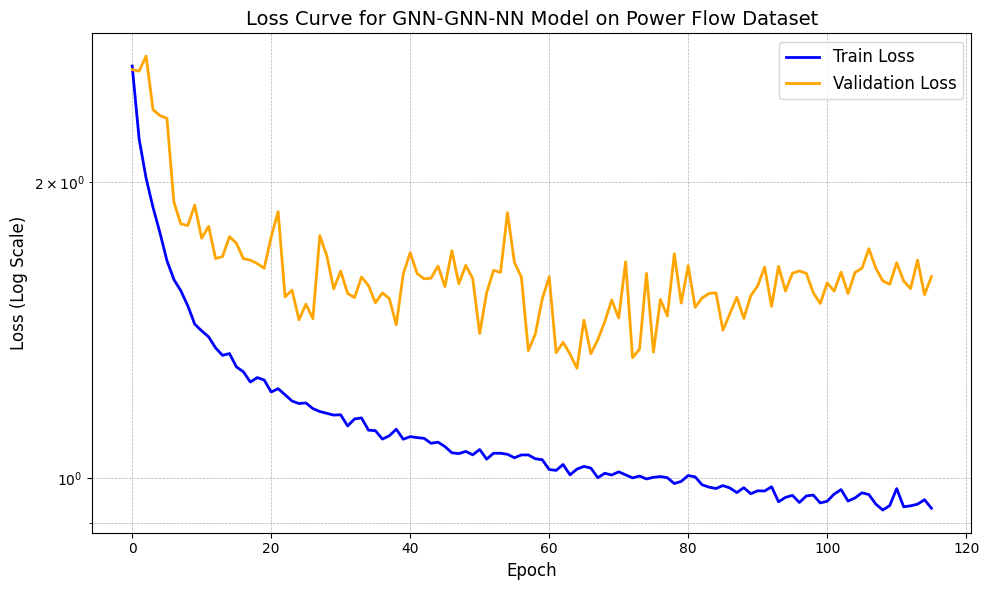

Last epoch: 116, Train loss: 0.9315722, Val loss: 1.6013086
Best epoch: 65, Best Train loss: 1.0209342, Best Val loss: 1.2923939


In [94]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 6))

#plt.title('Training and Validation Loss Curve for GNN-Based OPF on IEEE 14-Bus System', fontsize=14)
#plt.title('Training and Validation Loss Curve for GNN-Based OPF on IEEE 30-Bus System', fontsize=14)
plt.title('Training and Validation Loss Curve for GNN-Based OPF on IEEE 57-Bus System', fontsize=14)

plt.plot(train_loss_list, label="Train Loss", color='blue', linewidth=2)
plt.plot(val_loss_list, label="Validation Loss", color='orange', linewidth=2)
plt.yscale('log')  # Use logarithmic scale for better visualization
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss (Log Scale)", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

# Print final and best losses
print(f"Last epoch: {epoch + 1}, Train loss: {train_loss:.7f}, Val loss: {val_loss:.7f}")
print(f"Best epoch: {best_epoch + 1}, Best Train loss: {best_train_loss:.7f}, Best Val loss: {best_val_loss:.7f}")

# **Model Evaluation**

In [137]:
print(y_val_targets.shape)
print(y_val_predictions[0].shape)

torch.Size([400, 30, 2])
torch.Size([30, 2])


In [138]:
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Function to calculate regression metrics
def evaluate_regression_metrics(y_true, y_pred):
    # Denormalize the outputs
    y_true = denormalize_output(y_true, y_val_mean, y_val_std)
    y_pred = denormalize_output(y_pred, y_val_mean, y_val_std)

    # Convert to numpy arrays
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    # Calculate metrics
    mse = mean_squared_error(y_true.reshape(-1, 2), y_pred.reshape(-1, 2))
    rmse = np.sqrt(mse)
    nrmse = rmse / np.std(y_true)
    mae = mean_absolute_error(y_true.reshape(-1, 2), y_pred.reshape(-1, 2))
    r2 = r2_score(y_true.reshape(-1, 2), y_pred.reshape(-1, 2))

    # Print metrics
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Normalized RMSE (NRMSE): {nrmse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"R^2 Score: {r2:.6f}")

    return mse, rmse, nrmse, mae, r2

# Evaluation after training
model.eval()
y_val_predictions = []

# Collect all predictions and ground truth for the validation set
with torch.no_grad():
    for batch in val_loader:
        # Forward pass for validation
        y_val_pred = model(batch)

        # Reshape predictions to [n_bus, 2] to match the targets' structure
        y_val_pred = y_val_pred.view(n_bus, 2)
        y_val_predictions.append(y_val_pred)

# Stack predictions and targets with the shape [n_samples, n_bus, 2]
y_val_predictions = torch.stack(y_val_predictions, dim=0)
y_val_targets = torch.stack([batch.y.view(n_bus, 2) for batch in val_loader], dim=0)

# Calculate and print regression metrics
mse, rmse, nrmse, mae, r2 = evaluate_regression_metrics(y_val_targets, y_val_predictions)

# Save the metrics to a dictionary for later comparison
metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'NRMSE': nrmse,
    'MAE': mae,
    'R2': r2
}

# Optionally save the metrics to a CSV file
metrics_df = pd.DataFrame([metrics])

# Save the metrics to the CSV file
#metrics_df.to_csv("14_bus_validation_metrics.csv", index=False)
#print("\nMetrics saved to '14_bus_validation_metrics.csv'.")

#metrics_df.to_csv("30_bus_validation_metrics.csv", index=False)
#print("\nMetrics saved to '30_bus_validation_metrics.csv'.")

metrics_df.to_csv("57_bus_validation_metrics.csv", index=False)
print("\nMetrics saved to '57_bus_validation_metrics.csv'.")


Mean Squared Error (MSE): 1.601307
Root Mean Squared Error (RMSE): 1.265427
Normalized RMSE (NRMSE): 0.173280
Mean Absolute Error (MAE): 0.595381
R^2 Score: 0.968978

Metrics saved to '30_bus_validation_metrics.csv'.


# **Single datapoint evaluation**

In [140]:
# Set model to evaluation mode
model.eval()

# Device configuration (ensure compatibility)
device = next(model.parameters()).device

# Function for single datapoint evaluation
def evaluate_single_datapoint(data, y_mean, y_std, y_raw):
    # Move the data to the correct device
    data = data.to(device)

    # Forward pass
    y_pred = model(data)

    # Reshape predictions to match the target structure [n_bus, 2]
    y_pred = y_pred.view(n_bus, 2)
    data_y = data.y.view(n_bus, 2)

    # Denormalize the prediction and the ground truth
    y_pred_denorm = denormalize_output(y_pred, y_mean, y_std)
    y_target_denorm = denormalize_output(data_y, y_mean, y_std)

    # Compute loss
    loss = MSE(y_pred_denorm, y_target_denorm)

    # Print ground truth and prediction
    print("Ground-truth:", y_raw.detach().cpu().numpy())
    print("Prediction:", y_pred_denorm.detach().cpu().numpy())
    print(f"Loss (MSE): {loss:.7f}")

    return loss

# Evaluate on a single training datapoint
print("\nEvaluation on a single training datapoint:")
train_loss_1 = evaluate_single_datapoint(
    train_loader.dataset[0], y_val_mean, y_val_std, y_raw_train[0]
)

# Evaluate on a single validation datapoint
print("\nEvaluation on a single validation datapoint:")
val_loss_1 = evaluate_single_datapoint(
    val_loader.dataset[0], y_val_mean, y_val_std, y_raw_val[0]
)



Evaluation on a single training datapoint:
Ground-truth: [[ 0.       0.     ]
 [14.40134 13.22018]
 [ 2.99126  1.21511]
 [ 6.92581  2.21079]
 [ 0.       0.     ]
 [ 0.       0.     ]
 [15.86692 13.9925 ]
 [23.75827 19.8484 ]
 [ 0.       0.     ]
 [ 7.46975  2.51386]
 [ 0.       0.     ]
 [14.24347  8.09227]
 [ 0.       0.     ]
 [ 5.19604  1.98946]
 [ 8.39846  3.13083]
 [ 3.95501  1.30192]
 [ 6.31731  7.41053]
 [ 4.2316   1.24807]
 [10.36428  3.84165]
 [ 2.98069  0.45465]
 [21.10863 13.66907]
 [ 0.       0.     ]
 [ 3.72223  1.43751]
 [ 6.03425  8.3942 ]
 [ 0.       0.     ]
 [ 2.47779  2.2616 ]
 [ 0.       0.     ]
 [ 0.       0.     ]
 [ 2.91809  0.84565]
 [12.16662  1.42966]]
Prediction: [[ 0.00015 -0.00003]
 [15.22614 12.48808]
 [ 2.53103  1.17675]
 [ 7.73088  1.53132]
 [-0.0011   0.00188]
 [-0.00019 -0.00061]
 [14.01692 13.56758]
 [22.05197 24.59631]
 [-0.00128  0.00202]
 [ 7.08322  2.24986]
 [ 0.00008  0.00045]
 [12.55663  7.52172]
 [-0.00049  0.00017]
 [ 6.23372  1.67437]
 [ 8.

# **Testing on Multiple Datasets**

Loading the Best Model

In [145]:
best_model = My_GNN_GNN_NN(n_bus, feat_in, feat_size1, feat_size2, hidden_size1, output_size)

# Load the saved state dictionary
#state_dict = torch.load("[14 bus] Best_GNN_GNN_NN_model.pt")
#state_dict = torch.load("[30 bus] Best_GNN_GNN_NN_model.pt")
state_dict = torch.load("[57 bus] Best_GNN_GNN_NN_model.pt")

best_model.load_state_dict(state_dict, strict=False)

# Set the model to evaluation mode
best_model.eval()

<ipython-input-145-02b386e07922>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("[30 bus] Best_GNN_GNN_NN_model.pt")


My_GNN_GNN_NN(
  (conv1): GCNConv(7, 16)
  (conv2): GCNConv(16, 8)
  (lin1): Linear(in_features=240, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=60, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

# **NRMSE Function**

In [148]:
def NRMSE(yhat, y):
    rmse = torch.sqrt(torch.mean((yhat - y) ** 2))
    nrmse = rmse / torch.std(y)
    return nrmse

# **Test Dataset Evaluation Loop**

In [167]:
test_loss_list = []

for i in range(10):
    # Load the test dataset
    #dataset = pd.read_excel(f'/content/GNN-OptimalPowerFlow/Datasets/14Bus/PF_Dataset_{i + 1}.xlsx').values
    #dataset = pd.read_excel(f'/content/GNN-OptimalPowerFlow/Datasets/30Bus/PF_Dataset_{i + 1}.xlsx').values
    dataset = pd.read_excel(f'/content/GNN-OptimalPowerFlow/Datasets/57Bus/PF_Dataset_{i + 1}.xlsx').values

    test_dataset = slice_dataset(dataset, 20)  # Use 20% of the test dataset
    x_raw_test, y_raw_test = make_dataset(test_dataset, n_bus)
    x_norm_test, y_norm_test, y_test_mean, y_test_std, _, _ = normalize_dataset(x_raw_test, y_raw_test)

    # Extract only the target statistics (P and Q) from mean and std
    y_test_mean_targets = y_test_mean[:, :2]  # Shape: [30, 2]
    y_test_std_targets = y_test_std[:, :2]    # Shape: [30, 2]

    # Prepare test data loader
    data_test_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_test, y_norm_test)]
    test_loader = DataLoader(data_test_list, batch_size=1)

    # Initialize predictions
    yhat = torch.empty(0, n_bus, 2)  # Shape: [n_samples, n_bus, 2]

    # Collect predictions
    for batch in test_loader:
        y_pred = best_model(batch)
        y_pred = y_pred.view(n_bus, 2)  # Reshape to [n_bus, 2]
        yhat = torch.cat((yhat, y_pred.unsqueeze(0)))  # Add batch dimension

    # Denormalize using only target statistics (P and Q)
    yhat = denormalize_output(yhat, y_test_mean_targets, y_test_std_targets)
    y_raw_test_denorm = denormalize_output(y_norm_test[:, :, :2], y_test_mean_targets, y_test_std_targets)

    # Calculate NRMSE for the test dataset
    test_loss_NRMSE = NRMSE(yhat, y_raw_test_denorm)

    print(f"Dataset {i + 1} | Test loss (NRMSE): {test_loss_NRMSE:.7f}")
    test_loss_list.append(test_loss_NRMSE)

# Print summary of test losses
print("Test Losses for All Datasets:", test_loss_list)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 1 | Test loss (NRMSE): 0.6313335


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 2 | Test loss (NRMSE): 0.6338344


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 3 | Test loss (NRMSE): 0.6350325


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 4 | Test loss (NRMSE): 0.6327797


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 5 | Test loss (NRMSE): 0.6354052


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 6 | Test loss (NRMSE): 0.6348307


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 7 | Test loss (NRMSE): 0.6327806


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 8 | Test loss (NRMSE): 0.6342018


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 9 | Test loss (NRMSE): 0.6367190


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 10 | Test loss (NRMSE): 0.6351225
Test Losses for All Datasets: [tensor(0.63133, grad_fn=<DivBackward0>), tensor(0.63383, grad_fn=<DivBackward0>), tensor(0.63503, grad_fn=<DivBackward0>), tensor(0.63278, grad_fn=<DivBackward0>), tensor(0.63541, grad_fn=<DivBackward0>), tensor(0.63483, grad_fn=<DivBackward0>), tensor(0.63278, grad_fn=<DivBackward0>), tensor(0.63420, grad_fn=<DivBackward0>), tensor(0.63672, grad_fn=<DivBackward0>), tensor(0.63512, grad_fn=<DivBackward0>)]


# **Saving Test Losses**

In [168]:
import pandas as pd
import numpy as np

# Ensure the test_loss_list is converted to a format that can be saved
new_list = []

# Convert each test loss value to a float and detach from the computation graph if needed
for x in test_loss_list:
    if isinstance(x, torch.Tensor):
        new_list.append(x.item())  # Use .item() for scalar tensors
    else:
        new_list.append(float(x))  # Convert to float if it's already a number

# Create a DataFrame from the list
test_loss_df = pd.DataFrame(new_list, columns=["Test Loss"])

# Save the DataFrame to an Excel file
#test_loss_df.to_excel("[14 bus] Test Losses.xlsx", index=False)
#print("\nTest loss file saved successfully as '[14 bus] Test Losses.xlsx'!")

#test_loss_df.to_excel("[30 bus] Test Losses.xlsx", index=False)
#print("\nTest loss file saved successfully as '[30 bus] Test Losses.xlsx'!")

test_loss_df.to_excel("[57 bus] Test Losses.xlsx", index=False)
print("\nTest loss file saved successfully as '[57 bus] Test Losses.xlsx'!")


Test loss file saved successfully as '[30 bus] Test Losses.xlsx'!


In [40]:
"""
# Save test losses to Excel
new_list = []
for x in test_loss_list:
    new_list.append(x.detach().numpy())

test_loss_df = pd.DataFrame(new_list, columns=["Test Loss"])
test_loss_df.to_excel("[14 bus] Test Losses.xlsx", index=False)
print("\nTest loss file saved!")
"""


Test loss file saved!


# **IEEE 30 Bus DataSet Generation**

It Contains 30 buses, 6 generators, 21 loads, and 41 branches.

A classic test case for load flow and optimal power flow (OPF) studies.


In [1]:
pip install pandapower

In [10]:
import pandapower as pp
import pandapower.networks as nw
import pandas as pd
import random
import os

# Create the output folder
output_folder = "datasets_30Bus"
os.makedirs(output_folder, exist_ok=True)

# Create the 30-bus test system using pandapower
net = nw.case30()

# Number of datasets and samples per dataset
num_datasets = 10
samples_per_dataset = 2000
variation_range = 0.4  # ±40% random load variation

# columns for the output Excel file
bus_ids = net.bus.index
columns = []

# column names based on dataset format
for bus in bus_ids:
    columns.extend([f"P_{bus + 1} (PQ)", f"Q_{bus + 1} (PQ)", f"V_{bus + 1}", f"d_{bus + 1}"])

# Store original load values for resetting
original_p_values = net.load['p_mw'].copy()
original_q_values = net.load['q_mvar'].copy()

# Generate the datasets
for dataset_n in range(1, num_datasets + 1):
    print(f"Generating dataset {dataset_n}...")

    data = []

    # initial power flow to stabilize the network
    #try:
    #    pp.runpp(net, algorithm='nr', max_iteration=20)
    #except pp.LoadflowNotConverged:
    #    print(f"Initial load flow did not converge for dataset {dataset_n}, skipping this dataset.")
    #    continue

    for sample in range(1, samples_per_dataset + 1):
        # Reset the load values to the original values
        net.load['p_mw'] = original_p_values
        net.load['q_mvar'] = original_q_values

        # Apply random variation based on the original values
        for load in net.load.index:
            net.load.at[load, 'p_mw'] = original_p_values[load] * (1 + random.uniform(-variation_range, variation_range))
            net.load.at[load, 'q_mvar'] = original_q_values[load] * (1 + random.uniform(-variation_range, variation_range))

        # Run AC power flow with Newton-Raphson algorithm
        try:
            pp.runpp(net, algorithm='nr', max_iteration=20)
        except pp.LoadflowNotConverged:
            print(f"Load flow did not converge for sample {sample} in dataset {dataset_n}, skipping this sample.")
            continue

        # Collect data for the current sample
        row = []

        for bus in bus_ids:
            # Extract P and Q values for the bus (PQ buses only)
            if bus in net.load['bus'].values:
                p_load = net.res_load.loc[net.load[net.load['bus'] == bus].index, 'p_mw'].sum()
                q_load = net.res_load.loc[net.load[net.load['bus'] == bus].index, 'q_mvar'].sum()
            else:
                p_load, q_load = 0, 0

            # Extract V (voltage magnitude) and d (voltage angle)
            v_mag = net.res_bus.at[bus, 'vm_pu']
            v_ang = net.res_bus.at[bus, 'va_degree']

            # Append data to the row in the specified format
            row.extend([p_load, q_load, v_mag, v_ang])

        # Add the row to the dataset
        data.append(row)

    # Create a DataFrame and add headers in the requested format
    df = pd.DataFrame(data, columns=columns)

    df.insert(0, "Data", [f"Data {i + 1}" for i in range(len(df))])
    df.insert(0, "Dataset", [f"PF Dataset_{dataset_n}"] + [""] * (len(df) - 1))

    # Save the DataFrame to Excel
    output_filename = os.path.join(output_folder, f"PF_Dataset_{dataset_n}.xlsx")
    df.to_excel(output_filename, index=False)
    print(f"Dataset {dataset_n} saved to {output_filename}")

print("All datasets generated successfully.")


Generating dataset 1...
Dataset 1 saved to datasets/PF_Dataset_1.xlsx
Generating dataset 2...
Dataset 2 saved to datasets/PF_Dataset_2.xlsx
Generating dataset 3...
Dataset 3 saved to datasets/PF_Dataset_3.xlsx
Generating dataset 4...
Dataset 4 saved to datasets/PF_Dataset_4.xlsx
Generating dataset 5...
Dataset 5 saved to datasets/PF_Dataset_5.xlsx
Generating dataset 6...
Dataset 6 saved to datasets/PF_Dataset_6.xlsx
Generating dataset 7...
Dataset 7 saved to datasets/PF_Dataset_7.xlsx
Generating dataset 8...
Dataset 8 saved to datasets/PF_Dataset_8.xlsx
Generating dataset 9...
Dataset 9 saved to datasets/PF_Dataset_9.xlsx
Generating dataset 10...
Dataset 10 saved to datasets/PF_Dataset_10.xlsx
All datasets generated successfully.


 **30 Bus Generator Limits**

 Generated Active and Reactive Power (P and Q) should be bounded by their maximum and minimum capability for each bus.

 Otherwise the OPF will not converge for the network.

In [6]:
# Import pandas for cleaner output (optional)
import pandas as pd

# generator bus information
gen_buses = net.gen['bus'].values  # The bus indices with generators
p_gen = net.res_gen['p_mw'].values
q_gen = net.res_gen['q_mvar'].values

# detailed information for each generator
print("Generator Information:")
for i, bus in enumerate(gen_buses):
    p_max = net.gen.at[i, 'max_p_mw'] if 'max_p_mw' in net.gen.columns else "N/A"
    q_max = net.gen.at[i, 'max_q_mvar'] if 'max_q_mvar' in net.gen.columns else "N/A"
    print(f"Bus {bus} | Active Power (P_gen): {p_gen[i]:.2f} MW | Reactive Power (Q_gen): {q_gen[i]:.2f} MVar | P_max: {p_max} MW | Q_max: {q_max} MVar")

print("\nFull Generator DataFrame:")
print(net.gen)


Generator Information:
Bus 1 | Active Power (P_gen): 60.97 MW | Reactive Power (Q_gen): 37.38 MVar | P_max: 80.0 MW | Q_max: 60.0 MVar
Bus 21 | Active Power (P_gen): 21.59 MW | Reactive Power (Q_gen): 40.45 MVar | P_max: 50.0 MW | Q_max: 62.5 MVar
Bus 26 | Active Power (P_gen): 26.91 MW | Reactive Power (Q_gen): 11.79 MVar | P_max: 55.0 MW | Q_max: 48.7 MVar
Bus 22 | Active Power (P_gen): 19.20 MW | Reactive Power (Q_gen): 7.34 MVar | P_max: 30.0 MW | Q_max: 40.0 MVar
Bus 12 | Active Power (P_gen): 37.00 MW | Reactive Power (Q_gen): 10.96 MVar | P_max: 40.0 MW | Q_max: 44.7 MVar

Full Generator DataFrame:
   name  bus   p_mw  vm_pu  sn_mva  min_q_mvar  max_q_mvar  scaling  slack  \
0  None    1  60.97    1.0     NaN       -20.0        60.0      1.0  False   
1  None   21  21.59    1.0     NaN       -15.0        62.5      1.0  False   
2  None   26  26.91    1.0     NaN       -15.0        48.7      1.0  False   
3  None   22  19.20    1.0     NaN       -10.0        40.0      1.0  False 

In [4]:
import pandas as pd

# Initialize lists to track generator outputs
p_gen_list = []
q_gen_list = []

# Run power flow and log generator outputs for multiple test cases
for i in range(10):  # 10 datasets
    try:
        pp.runpp(net, algorithm='nr', max_iteration=20)

        # Get generator active and reactive power outputs
        p_gen = net.res_gen['p_mw'].values
        q_gen = net.res_gen['q_mvar'].values

        # Log the generator outputs
        p_gen_list.append(p_gen)
        q_gen_list.append(q_gen)

        print(f"Test Case {i + 1}:")
        print("Active Power (P_gen):", p_gen)
        print("Reactive Power (Q_gen):", q_gen)
        print("=" * 40)

    except pp.LoadflowNotConverged:
        print(f"Load flow did not converge for Test Case {i + 1}, skipping...")
        continue

# Convert to DataFrame for easier comparison
p_gen_df = pd.DataFrame(p_gen_list, columns=[f"P_gen_{i}" for i in range(len(p_gen))])
q_gen_df = pd.DataFrame(q_gen_list, columns=[f"Q_gen_{i}" for i in range(len(q_gen))])

# Save the results to Excel for further analysis
p_gen_df.to_excel("P_gen_changes.xlsx", index=False)
q_gen_df.to_excel("Q_gen_changes.xlsx", index=False)

print("Generator outputs logged and saved to 'P_gen_changes.xlsx' and 'Q_gen_changes.xlsx'.")


Test Case 1:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power (Q_gen): [37.38115789 40.44738087 11.79165197  7.33633467 10.95915525]
Test Case 2:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power (Q_gen): [37.38115789 40.44738087 11.79165197  7.33633467 10.95915525]
Test Case 3:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power (Q_gen): [37.38115789 40.44738087 11.79165197  7.33633467 10.95915525]
Test Case 4:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power (Q_gen): [37.38115789 40.44738087 11.79165197  7.33633467 10.95915525]
Test Case 5:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power (Q_gen): [37.38115789 40.44738087 11.79165197  7.33633467 10.95915525]
Test Case 6:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power (Q_gen): [37.38115789 40.44738087 11.79165197  7.33633467 10.95915525]
Test Case 7:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power 

# **IEEE 57 Bus DataSet Generation**

Contains 57 buses, 7 generators, 42 loads, and 80 branches.

Commonly used for testing load flow and contingency analysis.

In [12]:
pip install pandapower

In [13]:
import pandapower as pp
import pandapower.networks as nw
import pandas as pd
import random
import os

# Create the output folder
output_folder = "datasets_57Bus"
os.makedirs(output_folder, exist_ok=True)

# Load the 57-bus test system using pandapower
net = nw.case57()

# Number of datasets and samples per dataset
num_datasets = 10
samples_per_dataset = 2000
variation_range = 0.4  # ±40% random load variation

# Define the columns for the output Excel file
bus_ids = net.bus.index
columns = []

# Create column names based on your dataset format
for bus in bus_ids:
    columns.extend([f"P_{bus + 1} (PQ)", f"Q_{bus + 1} (PQ)", f"V_{bus + 1}", f"d_{bus + 1}"])

# Store original load values for resetting
original_p_values = net.load['p_mw'].copy()
original_q_values = net.load['q_mvar'].copy()

# Generate the datasets
for dataset_n in range(1, num_datasets + 1):
    print(f"Generating dataset {dataset_n}...")

    data = []

    for sample in range(1, samples_per_dataset + 1):
        # Reset the load values to the original values
        net.load['p_mw'] = original_p_values
        net.load['q_mvar'] = original_q_values

        # Apply random variation based on the original values
        for load in net.load.index:
            net.load.at[load, 'p_mw'] = original_p_values[load] * (1 + random.uniform(-variation_range, variation_range))
            net.load.at[load, 'q_mvar'] = original_q_values[load] * (1 + random.uniform(-variation_range, variation_range))

        # Run AC power flow with Newton-Raphson algorithm
        try:
            pp.runpp(net, algorithm='nr', max_iteration=30)
        except pp.LoadflowNotConverged:
            print(f"Load flow did not converge for sample {sample} in dataset {dataset_n}, skipping this sample.")
            continue

        # Collect data for the current sample
        row = []

        for bus in bus_ids:
            # Extract P and Q values for the bus (PQ buses only)
            if bus in net.load['bus'].values:
                p_load = net.res_load.loc[net.load[net.load['bus'] == bus].index, 'p_mw'].sum()
                q_load = net.res_load.loc[net.load[net.load['bus'] == bus].index, 'q_mvar'].sum()
            else:
                p_load, q_load = 0, 0

            # Extract V (voltage magnitude) and d (voltage angle)
            v_mag = net.res_bus.at[bus, 'vm_pu']
            v_ang = net.res_bus.at[bus, 'va_degree']

            # Append data to the row in the specified format
            row.extend([p_load, q_load, v_mag, v_ang])

        # Add the row to the dataset
        data.append(row)

    # Create a DataFrame and add headers in the requested format
    df = pd.DataFrame(data, columns=columns)
    df.insert(0, "Data", [f"Data {i + 1}" for i in range(len(df))])
    df.insert(0, "Dataset", [f"PF Dataset_{dataset_n}"] + [""] * (len(df) - 1))

    # Save the DataFrame to Excel
    output_filename = os.path.join(output_folder, f"PF_Dataset_{dataset_n}.xlsx")
    df.to_excel(output_filename, index=False)
    print(f"Dataset {dataset_n} saved to {output_filename}")

print("All datasets generated successfully.")


Generating dataset 1...
Dataset 1 saved to datasets_57Bus/PF_Dataset_1.xlsx
Generating dataset 2...
Dataset 2 saved to datasets_57Bus/PF_Dataset_2.xlsx
Generating dataset 3...
Dataset 3 saved to datasets_57Bus/PF_Dataset_3.xlsx
Generating dataset 4...
Dataset 4 saved to datasets_57Bus/PF_Dataset_4.xlsx
Generating dataset 5...
Dataset 5 saved to datasets_57Bus/PF_Dataset_5.xlsx
Generating dataset 6...
Dataset 6 saved to datasets_57Bus/PF_Dataset_6.xlsx
Generating dataset 7...
Dataset 7 saved to datasets_57Bus/PF_Dataset_7.xlsx
Generating dataset 8...
Dataset 8 saved to datasets_57Bus/PF_Dataset_8.xlsx
Generating dataset 9...
Dataset 9 saved to datasets_57Bus/PF_Dataset_9.xlsx
Generating dataset 10...
Dataset 10 saved to datasets_57Bus/PF_Dataset_10.xlsx
All datasets generated successfully.


**57 Bus Generator Limits**

 Generated Active and Reactive Power (P and Q) should be bounded by their maximum and minimum capability for each bus.

 Otherwise the OPF will not converge for the network.

In [15]:
# Import pandas for cleaner output
import pandas as pd

# generator bus information
gen_buses = net.gen['bus'].values  # The bus indices with generators
p_gen = net.res_gen['p_mw'].values
q_gen = net.res_gen['q_mvar'].values

# detailed information for each generator
print("Generator Information:")
for i, bus in enumerate(gen_buses):
    p_max = net.gen.at[i, 'max_p_mw'] if 'max_p_mw' in net.gen.columns else "N/A"
    q_max = net.gen.at[i, 'max_q_mvar'] if 'max_q_mvar' in net.gen.columns else "N/A"
    print(f"Bus {bus} | Active Power (P_gen): {p_gen[i]:.2f} MW | Reactive Power (Q_gen): {q_gen[i]:.2f} MVar | P_max: {p_max} MW | Q_max: {q_max} MVar")

print("\nFull Generator DataFrame:")
print(net.gen)


Generator Information:
Bus 1 | Active Power (P_gen): 0.00 MW | Reactive Power (Q_gen): 29.40 MVar | P_max: 100.0 MW | Q_max: 50.0 MVar
Bus 2 | Active Power (P_gen): 40.00 MW | Reactive Power (Q_gen): -9.46 MVar | P_max: 140.0 MW | Q_max: 60.0 MVar
Bus 5 | Active Power (P_gen): 0.00 MW | Reactive Power (Q_gen): 12.11 MVar | P_max: 100.0 MW | Q_max: 25.0 MVar
Bus 7 | Active Power (P_gen): 450.00 MW | Reactive Power (Q_gen): 74.54 MVar | P_max: 550.0 MW | Q_max: 200.0 MVar
Bus 8 | Active Power (P_gen): 0.00 MW | Reactive Power (Q_gen): -21.24 MVar | P_max: 100.0 MW | Q_max: 9.0 MVar
Bus 11 | Active Power (P_gen): 310.00 MW | Reactive Power (Q_gen): 109.47 MVar | P_max: 410.0 MW | Q_max: 155.0 MVar

Full Generator DataFrame:
   name  bus   p_mw  vm_pu  sn_mva  min_q_mvar  max_q_mvar  scaling  slack  \
0  None    1    0.0  1.010     NaN       -17.0        50.0      1.0  False   
1  None    2   40.0  0.985     NaN       -10.0        60.0      1.0  False   
2  None    5    0.0  0.980     NaN 

# **Histogram**

Histograms is used to see which architecture has a better and more consistent performance (narrower, left-skewed distribution)

Histograms is used to compare:

1.   Different bus systems (e.g., 14-bus vs. 30-bus vs. 57-bus) using the same GNN architecture.

2.   It can also be used to compare different GNN architectures for a same network to see the effect


**Histogram Goal:**



*   Mean and Median Values: Lower mean and median values indicate better performance.

*   Spread of Distribution: A narrower histogram indicates more consistent performance (less variance).

*   Left-Skewed Distribution: A left-skewed histogram (with most losses near zero) indicates good generalization.



In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the test loss data from each Excel file
bus_14_loss_data = pd.read_excel('[14 bus] Test Losses.xlsx').values.flatten()
bus_30_loss_data = pd.read_excel('[30 bus] Test Losses.xlsx').values.flatten()

# mean and median for each bus system
mean_14 = np.mean(bus_14_loss_data)
median_14 = np.median(bus_14_loss_data)

mean_30 = np.mean(bus_30_loss_data)
median_30 = np.median(bus_30_loss_data)


# Print the statistics
print(f"14-bus system - Mean: {mean_14:.5f}, Median: {median_14:.5f}")
print(f"30-bus system - Mean: {mean_30:.5f}, Median: {median_30:.5f}")

# histogram plotting parameters
kwargs = dict(histtype='stepfilled', alpha=0.5, density=True, bins=20)

# labels for the histograms
label_14 = f"14-bus, Mean: {mean_14:.5f}, Median: {median_14:.5f}"
label_30 = f"30-bus, Mean: {mean_30:.5f}, Median: {median_30:.5f}"

# Plot the histograms
plt.figure(figsize=(10, 6))
plt.hist(bus_14_loss_data, label=label_14, **kwargs)
plt.hist(bus_30_loss_data, label=label_30, **kwargs)

# plot details
plt.title('Comparison of Test Loss Distributions Across Different Test Case Networks')
plt.xlabel('Test Loss (MSE or NRMSE)')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '[14 bus] Test Losses.xlsx'